### Prepare the train data, test data

In [25]:
import pandas as pd

reviews_df = pd.read_csv('../02.Dataset/reviews_300k.csv')

In [26]:
filtered_df = reviews_df.groupby("userId").filter(lambda x: len(x) > 3)

In [27]:
filtered_df.head()

,userId,productId,rating,comment
0,1394862,102440084,5,Tác phẩm có giá trị về tuyên truyền hơn là giá...
2,2169793,102440084,4,NaN
4,28687742,102440084,5,NaN
8,16933741,102440084,5,NaN
10,5365732,102440084,5,NaN


In [28]:
filtered_df.query("userId == 1394862").head(10)

,userId,productId,rating,comment
0,1394862,102440084,5,Tác phẩm có giá trị về tuyên truyền hơn là giá...
817,1394862,14453314,5,NaN
3538,1394862,273119477,5,Bản in rất đẹp. Nội dung chắc không cần thiết ...
7874,1394862,50277621,4,NaN
220651,1394862,3082815,4,NaN
246559,1394862,52788072,5,NaN
261450,1394862,633125,5,NaN
280584,1394862,74021317,5,NaN


In [29]:
from sklearn.model_selection import train_test_split


train_splits = []
test_splits = []

for user_id, group in filtered_df.groupby("userId"):
    train_split, test_split = train_test_split(group, test_size=0.2, random_state=42)
    train_splits.append(train_split)
    test_splits.append(test_split)

train_df = pd.concat(train_splits).reset_index(drop=True)
test_df = pd.concat(test_splits).reset_index(drop=True)

In [30]:
train_df.query("userId == 1394862").head(10)

,userId,productId,rating,comment
8722,1394862,102440084,5,Tác phẩm có giá trị về tuyên truyền hơn là giá...
8723,1394862,74021317,5,NaN
8724,1394862,273119477,5,Bản in rất đẹp. Nội dung chắc không cần thiết ...
8725,1394862,3082815,4,NaN
8726,1394862,50277621,4,NaN
8727,1394862,633125,5,NaN


In [31]:
test_df.query("userId == 1394862").head(10)

,userId,productId,rating,comment
2862,1394862,14453314,5,NaN
2863,1394862,52788072,5,NaN


In [32]:
print(f"Number of Reviews for train: {len(train_df)}")
print(f"Number of Reviews for test: {len(test_df)}")

Number of Reviews for train: 55212
Number of Reviews for test: 18059


### Evaluate the MF model

In [33]:
# from mf_model import evaluate_mf_model

# P, Q, user_to_index, product_to_index = evaluate_mf_model(train_df, test_df)

### Evaluate the MF model with filtering review

In [34]:
import joblib

sentiment_analysis_model = joblib.load("../05.Models/20250518_sentiment_analysis_model.pkl")

In [35]:
import csv
import string
import emoji
import re
from pyvi import ViTokenizer
import pandas as pd
from functools import lru_cache


# === Cached loading ===
# @lru_cache(maxsize=1)
def load_teencode_dict():
    with open(
        "../02.Dataset/vietnamese/teencode.csv", mode="r", encoding="utf-8"
    ) as file:
        reader = csv.DictReader(file)
        return {row["Teencode"]: row["Meaning"] for row in reader}


# @lru_cache(maxsize=1)
def load_stopwords():
    with open("../02.Dataset/vietnamese/stopwords.txt", "r", encoding="utf-8") as f:
        return set(line.strip().lower() for line in f if line.strip())


# @lru_cache(maxsize=1)
def load_phrase_rules():
    rules = {}
    with open(
        "../02.Dataset/vietnamese/phrase_rules.csv", mode="r", encoding="utf-8"
    ) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row["Phrase"] and row["Normalized"]:
                rules[row["Phrase"].strip()] = row["Normalized"].strip()
    return rules


# === Text Cleaning ===
def clean_icons(text):
    if pd.isna(text):
        return ""
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"[:;][-~]?[)D(/\\|pP]", "", text)
    return text.replace("_x000D_", " ")


def lower(text):
    return text.lower().strip() if isinstance(text, str) else ""


def remove_links(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)


def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))


# === Teencode conversion ===
def convert_teencode_to_vietnamese(sentence):
    if pd.isna(sentence):
        return ""
    dictionary = load_teencode_dict()
    words = sentence.split()
    converted_words = []
    for word in words:
        core_word = word.strip(string.punctuation)
        if core_word in dictionary:
            new_word = word.replace(core_word, dictionary[core_word])
            new_word = new_word.replace(" ", "_")
            converted_words.append(new_word)
        else:
            converted_words.append(word)
    return " ".join(converted_words)


# === Stopwords removal ===
def remove_vietnamese_stopwords(text):
    if pd.isna(text):
        return ""
    stopwords = load_stopwords()
    words = text.split()
    result = []
    i = 0
    while i < len(words):
        if i < len(words) - 1:
            two_word = f"{words[i]}_{words[i+1]}"
            if two_word in stopwords:
                i += 2
                continue
        if words[i] not in stopwords:
            result.append(words[i])
        i += 1
    return " ".join(result)


# === Tokenization ===
def word_tokenize(text):
    if pd.isna(text):
        return ""
    return ViTokenizer.tokenize(text)


def apply_phrase_rules(text):
    if pd.isna(text):
        return ""
    rules = load_phrase_rules()

    for phrase, normalized in sorted(
        rules.items(), key=lambda x: len(x[0]), reverse=True
    ):
        text = re.sub(rf"\b{re.escape(phrase)}\b", normalized, text)

    negation_words = {"không", "chưa", "thiếu", "đừng", "chẳng"}
    words = text.split()
    merged_words = []
    i = 0
    while i < len(words):
        if words[i].lower() in negation_words and i + 1 < len(words):
            merged_words.append(f"{words[i]}_{words[i+1]}")
            i += 2
        else:
            merged_words.append(words[i])
            i += 1
    text = " ".join(merged_words)

    return text


# === Full Preprocessing Pipeline ===
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = clean_icons(text)
    text = lower(text)
    text = remove_punctuation(text)
    text = remove_links(text)
    text = convert_teencode_to_vietnamese(text)
    text = remove_vietnamese_stopwords(text)
    text = apply_phrase_rules(text)
    text = word_tokenize(text)
    return text

In [36]:
import numpy as np
from utils import preprocess_text

train_df['sentiment'] = np.nan

comments_with_text = train_df["comment"].dropna()

comments_with_text = comments_with_text.apply(preprocess_text)

predictions = sentiment_analysis_model.predict(comments_with_text.tolist())

train_df.loc[comments_with_text.index, "sentiment"] = predictions

C:\Users\LT64\AppData\Local\Temp\ipykernel_3276\3636286216.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['pos' 'pos' 'neg' ... 'pos' 'pos' 'pos']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df.loc[comments_with_text.index, "sentiment"] = predictions


In [37]:
train_df.head(10)

,userId,productId,rating,comment,sentiment
0,617,3304875,5,"Truyện hay, lôi cuốn, cảm xúc.",pos
1,617,48613094,5,"hình thức đẹp, nội dung súc tích!",pos
2,617,17336364,5,NaN,NaN
3,745,82996522,5,NaN,NaN
4,745,50277621,5,NaN,NaN
5,745,73787185,5,NaN,NaN
6,745,70844532,5,NaN,NaN
7,1086,7982628,5,NaN,NaN
8,1086,1938895,5,NaN,NaN
9,1086,52788072,5,NaN,NaN


In [38]:
train_df[train_df["sentiment"] == 'neg'].head(100)

,userId,productId,rating,comment,sentiment
10,1176,750578,5,cuộc chiến sức khoẻ mỗi ngày đối chọi với rủi ...,neg
15,1196,106365090,5,Tác phẩm kinh điển của Trung Quốc và bản dịch ...,neg
56,4178,208289682,5,Quá toẹt vời luônggggg 😍😍😍,neg
69,4947,2496281,2,trước giờ mình thường mua thể loại trình thám ...,neg
70,4947,12377498,2,nhân đợt sale 40% mình mua để trải nghiệm. Khi...,neg
...,...,...,...,...,...
1773,175796,136143567,5,Cuốn sách cung cấp thêm cho mình các chỉ số kh...,neg
1798,177919,87959748,5,Một nơi mà chỉ tồn tại lính phóng hoả thay cho...,neg
1802,177946,277425002,4,"Góc sách, bìa sách bị gãy",neg
1804,177946,195545504,3,"Goac sách, bìa sách bị gãy",neg


In [39]:
train_df[train_df["sentiment"] == "pos"].head(10)

,userId,productId,rating,comment,sentiment
0,617,3304875,5,"Truyện hay, lôi cuốn, cảm xúc.",pos
1,617,48613094,5,"hình thức đẹp, nội dung súc tích!",pos
13,1176,49910019,5,chia sẻ bổ ích cho chăm sóc trẻ,pos
14,1196,33492447,5,Cuốn sách thực sự xứng đáng là cuốn tiểu thuyế...,pos
18,1196,263066292,3,"Nội dung không đặc sắc, và khác biệt với các t...",pos
49,2426,102887973,5,"Đọc cái tựa cứ nghĩ là truyện tình cảm chứ,kh ...",pos
50,2426,33543689,5,"Một cuốn sách giá trị,in ấn đẹp. Rất đáng mua....",pos
51,2426,106863963,5,hay,pos
52,3720,120219394,5,"Rất hài lòng với dịch vụ Tiki, nội dung sách t...",pos
53,3720,3608625,3,Mình có mua cùng lúc nhiều sách chung chủ đề v...,pos


In [40]:
# Define the condition for invalid reviews
invalid_condition = ((train_df["sentiment"] == "neg") & (train_df["rating"] >= 4)) | (
    (train_df["sentiment"] == "pos") & (train_df["rating"] <= 2)
)

# Count the number of invalid reviews
num_invalid_reviews = invalid_condition.sum()

print(f"Number of invalid reviews: {num_invalid_reviews}")


Number of invalid reviews: 2954


In [41]:
def is_review_valid(row):
    if (row["sentiment"] == "neg" and row["rating"] >= 4) or (
        row["sentiment"] == "pos" and row["rating"] <= 2
    ):
        return "Invalid"
    return "Valid"


train_df["consistency"] = train_df.apply(is_review_valid, axis=1)

In [42]:
train_df.head(100)

,userId,productId,rating,comment,sentiment,consistency
0,617,3304875,5,"Truyện hay, lôi cuốn, cảm xúc.",pos,Valid
1,617,48613094,5,"hình thức đẹp, nội dung súc tích!",pos,Valid
2,617,17336364,5,NaN,NaN,Valid
3,745,82996522,5,NaN,NaN,Valid
4,745,50277621,5,NaN,NaN,Valid
...,...,...,...,...,...,...
95,5632,3954355,5,NaN,NaN,Valid
96,5632,381234,4,"Khi còn làm thực tập nhân sự cách đây 2 năm, t...",pos,Valid
97,5632,3639597,5,NaN,NaN,Valid
98,5881,74021317,4,NaN,NaN,Valid


In [43]:
# Remove rows labeled as "Valid"
invalid_reviews = train_df[train_df["consistency"] == "Invalid"].reset_index(drop=True)

print(f'Number of Invalid reviews: {len(invalid_reviews)}')

Number of Invalid reviews: 2954


In [44]:
invalid_reviews.to_csv('../02.Dataset/invalid_reviews.csv')

In [45]:
# Remove rows labeled as "Invalid"
valid_reviews = train_df[train_df["consistency"] == "Valid"].reset_index(drop=True)

Epoch 1/50 - Train RMSE: 4.8897 - Test RMSE: 4.8868
Epoch 2/50 - Train RMSE: 4.8894 - Test RMSE: 4.8867
Epoch 3/50 - Train RMSE: 4.8865 - Test RMSE: 4.8850
Epoch 4/50 - Train RMSE: 4.8489 - Test RMSE: 4.8607
Epoch 5/50 - Train RMSE: 4.5195 - Test RMSE: 4.6311
Epoch 6/50 - Train RMSE: 3.7498 - Test RMSE: 3.9855
Epoch 7/50 - Train RMSE: 2.9725 - Test RMSE: 3.2730
Epoch 8/50 - Train RMSE: 2.3824 - Test RMSE: 2.7042
Epoch 9/50 - Train RMSE: 1.9549 - Test RMSE: 2.2774
Epoch 10/50 - Train RMSE: 1.6431 - Test RMSE: 1.9602
Epoch 11/50 - Train RMSE: 1.4125 - Test RMSE: 1.7224
Epoch 12/50 - Train RMSE: 1.2389 - Test RMSE: 1.5409
Epoch 13/50 - Train RMSE: 1.1056 - Test RMSE: 1.3998
Epoch 14/50 - Train RMSE: 1.0009 - Test RMSE: 1.2880
Epoch 15/50 - Train RMSE: 0.9170 - Test RMSE: 1.1977
Epoch 16/50 - Train RMSE: 0.8487 - Test RMSE: 1.1238
Epoch 17/50 - Train RMSE: 0.7920 - Test RMSE: 1.0624
Epoch 18/50 - Train RMSE: 0.7444 - Test RMSE: 1.0108
Epoch 19/50 - Train RMSE: 0.7041 - Test RMSE: 0.9670
Ep

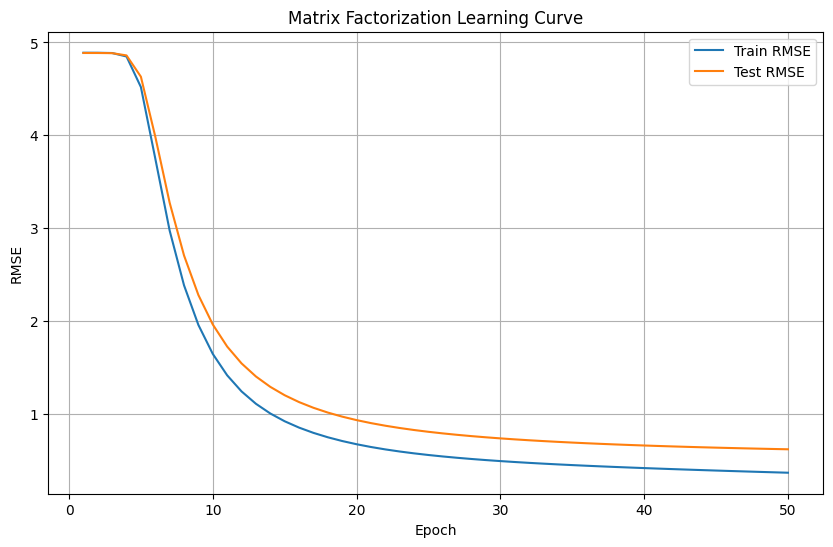

Epoch 1/50 - Train RMSE: 4.8982 - Test RMSE: 4.8868
Epoch 2/50 - Train RMSE: 4.8978 - Test RMSE: 4.8867
Epoch 3/50 - Train RMSE: 4.8939 - Test RMSE: 4.8844
Epoch 4/50 - Train RMSE: 4.8478 - Test RMSE: 4.8560
Epoch 5/50 - Train RMSE: 4.5039 - Test RMSE: 4.6220
Epoch 6/50 - Train RMSE: 3.7725 - Test RMSE: 4.0148
Epoch 7/50 - Train RMSE: 3.0216 - Test RMSE: 3.3371
Epoch 8/50 - Train RMSE: 2.4405 - Test RMSE: 2.7865
Epoch 9/50 - Train RMSE: 2.0144 - Test RMSE: 2.3682
Epoch 10/50 - Train RMSE: 1.6998 - Test RMSE: 2.0530
Epoch 11/50 - Train RMSE: 1.4642 - Test RMSE: 1.8141
Epoch 12/50 - Train RMSE: 1.2846 - Test RMSE: 1.6304
Epoch 13/50 - Train RMSE: 1.1454 - Test RMSE: 1.4871
Epoch 14/50 - Train RMSE: 1.0352 - Test RMSE: 1.3730
Epoch 15/50 - Train RMSE: 0.9464 - Test RMSE: 1.2807
Epoch 16/50 - Train RMSE: 0.8736 - Test RMSE: 1.2050
Epoch 17/50 - Train RMSE: 0.8133 - Test RMSE: 1.1423
Epoch 18/50 - Train RMSE: 0.7625 - Test RMSE: 1.0896
Epoch 19/50 - Train RMSE: 0.7194 - Test RMSE: 1.0449
Ep

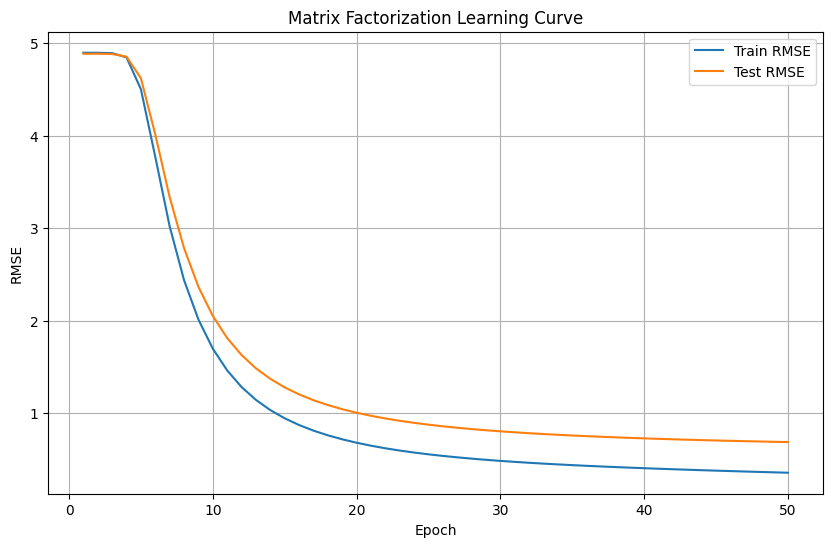

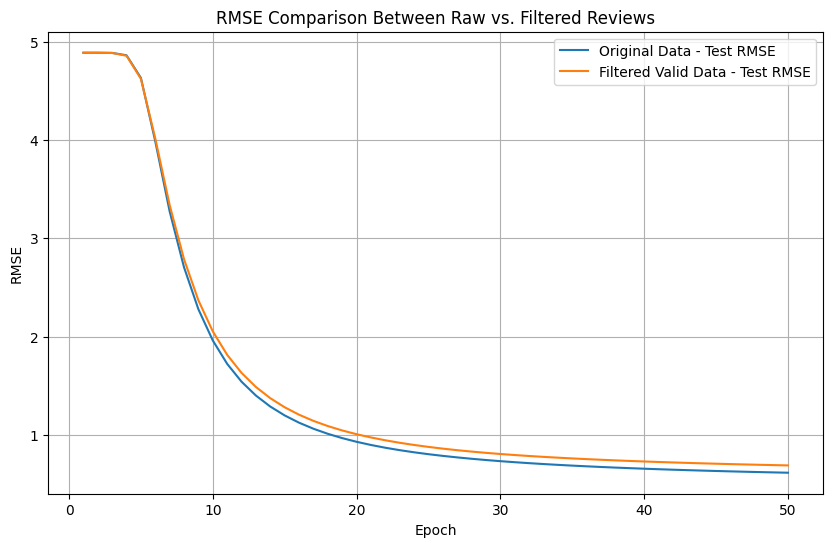

In [46]:
from matplotlib import pyplot as plt
from mf_model import evaluate_mf_model

# Run both models and collect RMSE
P1, Q1, u2i_1, p2i_1, train_rmse_1, test_rmse_1 = evaluate_mf_model(train_df, test_df)
P2, Q2, u2i_2, p2i_2, train_rmse_2, test_rmse_2 = evaluate_mf_model(
    valid_reviews, test_df
)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_rmse_1) + 1), test_rmse_1, label="Original Data - Test RMSE")
plt.plot(
    range(1, len(test_rmse_2) + 1), test_rmse_2, label="Filtered Valid Data - Test RMSE"
)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE Comparison Between Raw vs. Filtered Reviews")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Get final RMSE values from both models
original_rmse = test_rmse_1[-1]
filtered_rmse = test_rmse_2[-1]

# Calculate percentage improvement
improvement_percent = ((original_rmse - filtered_rmse) / original_rmse) * 100

print(f"Original Final Test RMSE: {original_rmse:.4f}")
print(f"Filtered Final Test RMSE: {filtered_rmse:.4f}")
print(f"Improvement: {improvement_percent:.2f}%")

Original Final Test RMSE: 0.6150
Filtered Final Test RMSE: 0.6893
Improvement: -12.08%
